Let's look at how to use the topological advection algorithm.  In this notebook we will consider the case of trajectories that are within a bounded region of the plane.  We will generate some trajectories and then get to work.

In [1]:
import numpy as np
import sys
import scipy.io as sio
sys.path.append("../src")  # accessing the source folder
import topological_advection as TA
from scipy.integrate import solve_ivp

Let's use chaotic lid-driven cavity flow as example system.  A description of this analytically defined flow can be found [in this arXiv paper](https://arxiv.org/abs/1809.01005).  We provide $\vec{V}(x,y,t)$ and use an ODE solver to get the trajectories from $\frac{d \vec{r}}{dt} = \vec{V}(x,y,t)$.

In [72]:
# global parameters 
U1 = 9.92786
U2 = 8.34932 
a = 6
b = 1
tau = 0.96
params = [a,b,U1,U2,tau]

# Computational Parameters
T_i = 0  # Starting time
T_f = 4  # final time (seconds)
# Rectangular Domain
x_l = 0  # x-range left
x_r = params[0] #x-range right
y_b = -1*params[1]   #Rectangular Domain, y-range bottom
y_t = params[1]   #Rectangular Domain, y-range top

T_num = 100 # number of time-steps to take
#  will use equally spaceed time-steps, though this is not neccesary
dt = (T_f-T_i)/T_num   # The time-step to use
times =  np.arange(T_i, T_f, dt)  #the set of times used in the ode solver

# the velocity vector function
def VelFunc(t,z,p):    
    x,y = z
    a, b, U1, U2, tau = p
    div = t/tau - np.floor(t/tau)
    Vx, Vy = 0, 0
    if div<0.5:
        Vx = (U1*CFunc(1,a,b)*derivativefFunc(1,y,a,b)*np.sin(np.pi*x/a)
              + U2*CFunc(2,a,b)*derivativefFunc(2,y,a,b)*np.sin(2*np.pi*x/a))
        Vy = (-U1*CFunc(1,a,b)*fFunc(1,y,a,b)*np.pi*np.cos(np.pi*x/a)/a
              - U2*CFunc(2,a,b)*fFunc(2,y,a,b)*2*np.pi*np.cos(2*np.pi*x/a)/a)
    else:
        Vx = (-U1*CFunc(1,a,b)*derivativefFunc(1,y,a,b)*np.sin(np.pi*x/a)
              + U2*CFunc(2,a,b)*derivativefFunc(2,y,a,b)*np.sin(2*np.pi*x/a))
        Vy = (U1*CFunc(1,a,b)*fFunc(1,y,a,b)*np.pi*np.cos(np.pi*x/a)/a
              - U2*CFunc(2,a,b)*fFunc(2,y,a,b)*2*np.pi*np.cos(2*np.pi*x/a)/a)
    return [Vx,Vy]

def CFunc(k,a,b): # Helper C_k function
    return ((a**2/(2*k*(np.pi**2)*b)) * 
            (1/((a/(2*k*np.pi*b)) * 
                np.sinh(2*k*np.pi*b/a)+1)))

def fFunc(k,y,a,b): # Helper F_k function
    return (2*np.pi*y*np.cosh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/a
              - 2*np.pi*b*np.sinh(k*np.pi*b/a)*np.cosh(k*np.pi*y/a)/a)

def derivativefFunc(k,y,a,b): # Helper derivative of F_k function
    return (2*np.pi*np.cosh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/a
            + 2*k*(np.pi**2)*y*np.cosh(k*np.pi*b/a)*np.cosh(k*np.pi*y/a)/(a**2)
            - 2*k*(np.pi**2)*b*np.sinh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/(a**2))

# Initialize the particles with random positions in the domain
Ntot =  200  # the total number of initial points to seed
de = 0.1  # Small factor to get points away from the edge
InitCond = [] # list of the initial conditions
for i in range(Ntot):
    InitCond.append([np.random.uniform(x_l+de, x_r-de),
                     np.random.uniform(y_b+de, y_t-de)])

# Now we run each inital condition through the ode solver
Traj = []  # for the trajectories
for IC in InitCond:
    Traj.append(solve_ivp(fun=VelFunc, t_span=(T_i,T_f), y0=IC,
                          method='Radau', t_eval=times, args=(params,)).y.T)


Now we can illustrate features of the topological advection algorithm with this trajectory set.  The very first thing to to is make sure that we have the correct data structure for the trajectories.  Currently Traj has the signature Traj[trajectory id][time][x/y], but we need to have it as time slices (time as the first index): Tslice[time][trajectory id][x/y].  So, let's reformat it:

In [90]:
# converting a set of trajectories to a set of time-slices
Tslices = []
for t in range(len(times)):
    Tslices.append([Traj[p][t].tolist() for p in range(len(Traj))])

First we need to initialize a topological_advection object with the time-slices and time array.  We can optionally pass in the bounding domain, if we know it (if we don't, it will be automatically calculated from min/max x/y trajectory values).

Also, importantly, we are letting the PeriodicBC flag take its default value of False, indicating that we will use the module for bounded trajectories (and not for periodic boundary conditions).

In [107]:
# Domain=[[x_l, y_b], [x_r, y_t]] could pass this in, but better to let
# the bounding rectangle be calculated automatically
TopAdvec = TA.TopologicalAdvection(Tslices, times)

Before doing any work with this object, let's first plot the triangulation to see what we have. 

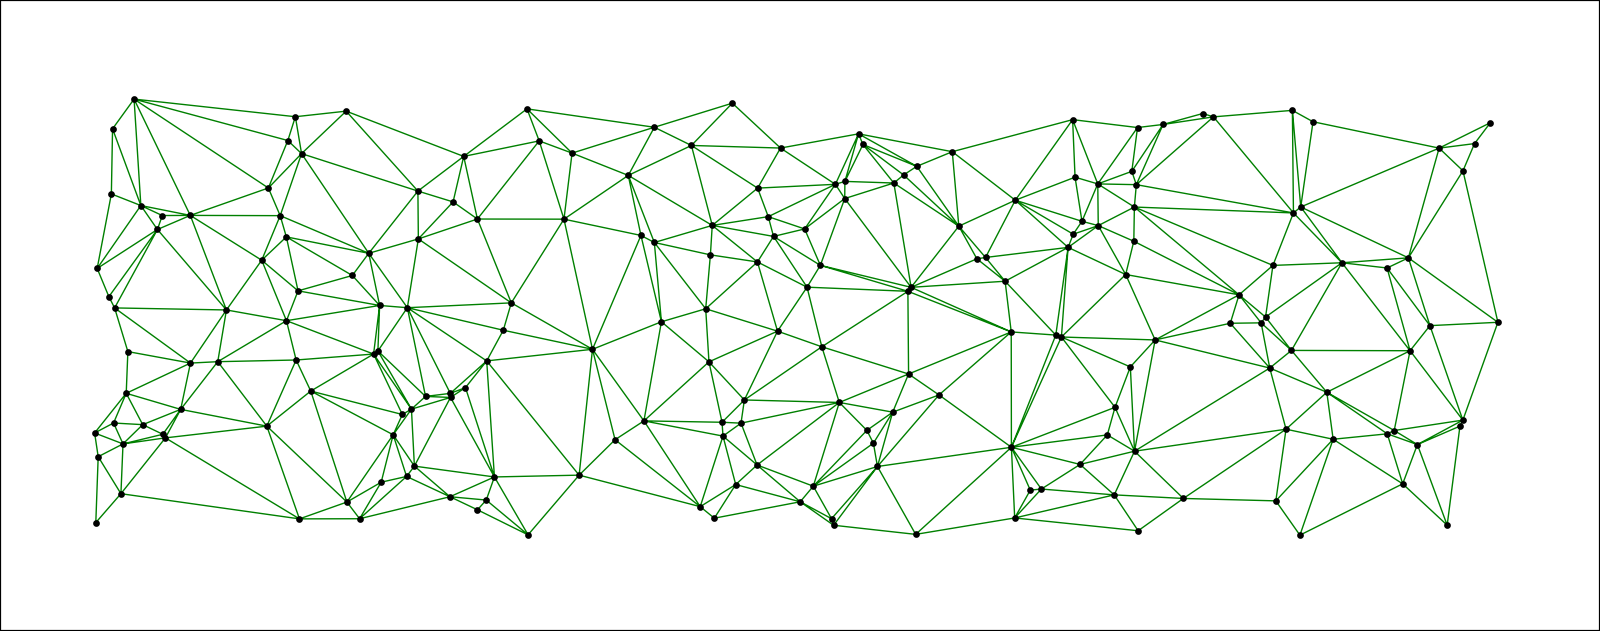

In [114]:
# Done have a loop to plot yet, so we set PlotLoop = False
# We want to plot the triangulation at the intial time-slice, so
# set Initial = True
TopAdvec.Plot(PlotLoop = False, Initial = True)

The first step to plotting is to set the PlotParamters attribute of our TopAdvec object (there are default values, but you might want to change them). If you want to know the current set of values for the plotting parameters, use the PrintPlotParameters method:

In [99]:
TopAdvec.PrintPlotParameters()

filename: None
triplot: True
Delaunay: False
DelaunayAdd: False
Bounds: [[0, -1], [6, 1]]
FigureSizeX: 8
dpi: 200
ptlabels: False
markersize: 2.0
linewidth_tri: 0.5
linecolor_tri: g
color_weights: False
log_color: True
color_map: inferno_r
linewidth_tt: 1.0
linecolor_tt: r
alpha_tt: 1.0
frac: 0.9
tt_lw_min_frac: 0.05
_conversion_factor: None
_max_weight: None
boundary_points: False
ExpandedBounds: [[np.float64(-0.2574191994478951), np.float64(-1.2698415596963424)], [np.float64(6.257419199447894), np.float64(1.2698415596963424)]]


To modify the plotting parameters, we call the set SetPlotParameters method.  Let's view the boundary points by setting boundary_points = True, set the point maker size to be larger (markersize = 2), change the triangluation line color (linecolor_tri = 'c'), and line width (linewidth_tri = 1.5)

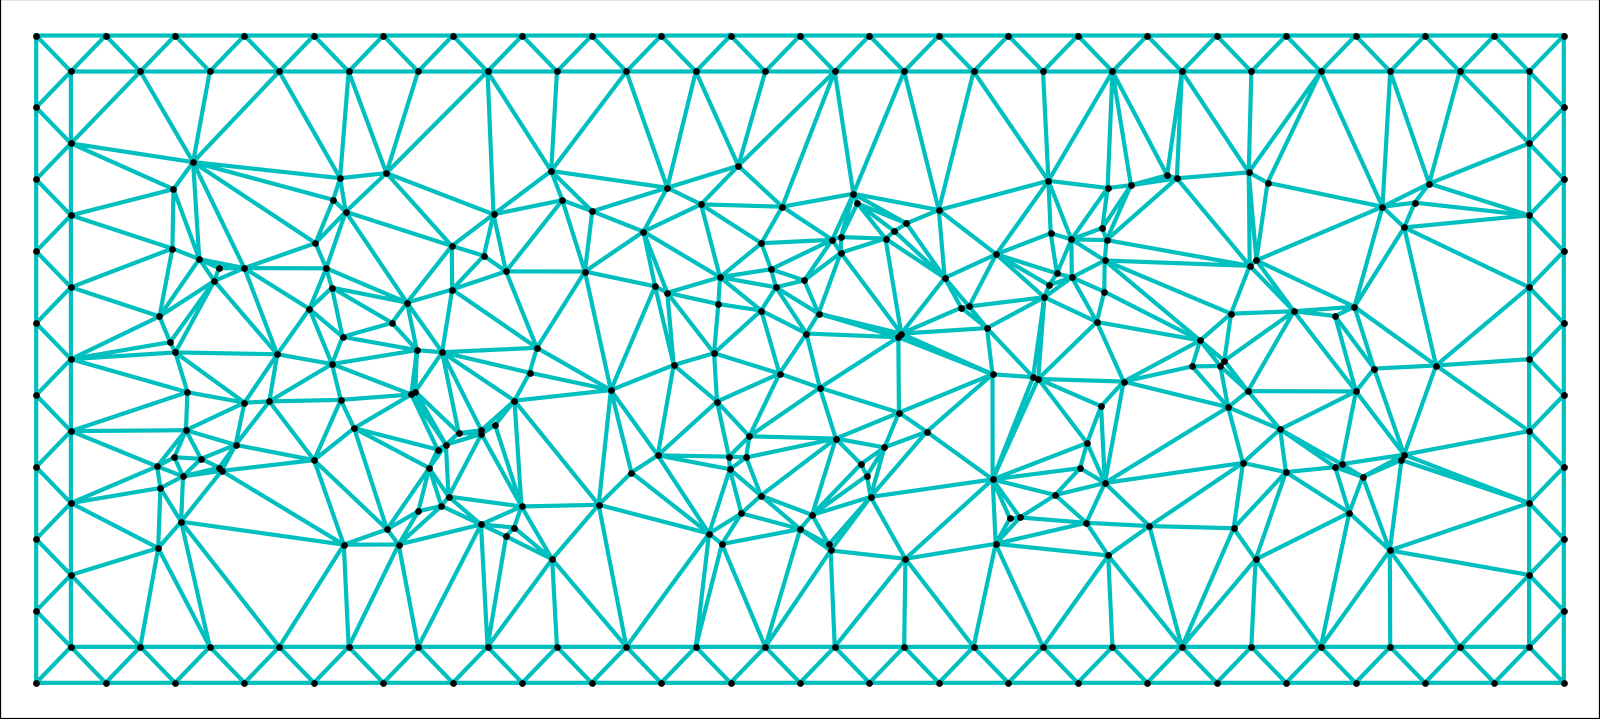

In [117]:
TopAdvec.SetPlotParameters(markersize = 2, boundary_points = True,
                           linecolor_tri = 'c', linewidth_tri = 1.5)
TopAdvec.Plot(PlotLoop = False, Initial = True)

To restore the default plotting parameters, use the ResetPlotParametersDefault method:

In [120]:
TopAdvec.ResetPlotParametersDefault()